In [18]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from torchtext.vocab import GloVe
import torchtext
from torchtext.data import get_tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 

In [6]:
file_path = '../data/processed/full_2k.csv'
df = pd.read_csv(file_path)

In [7]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])
num_classes = len(le.classes_)

df.head(5)

,Description,Category,label
0,The Russian author offers an affectionate chro...,Biography,0
1,"""The Bible and the social and moral consequenc...",Religion,8
2,A New York Times Notable Book of the YearThis ...,Biography,0
3,"It was a wonderful summer, a great memory, the...",General,3
4,"For the first time ever, veteran World War II ...",History,4


In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['cleaned_desc'] = df['Description'].apply(clean_text)

In [9]:
# First, split off 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    df['cleaned_desc'], df['label'], 
    test_size=0.1, stratify=df['label'], random_state=13)

# Then split temp into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.11111111111111,
    stratify=y_temp, random_state=13)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 27543, Val: 3443, Test: 3443


In [10]:
glove = GloVe(name='6B', dim=300)

def sentence_to_sequence(sentence, glove, max_len=300):
    """
    Convert a sentence into a tensor of GloVe vectors (seq_len, embedding_dim).
    Pads or truncates to max_len.
    """
    # Handle N/A sentences
    if not isinstance(sentence, str) or len(sentence.strip()) == 0:
        return torch.zeros(max_len, glove.dim)
    
    words = sentence.split()
    vecs = [glove[word] for word in words if word in glove.stoi]

    # If sentence has fewer than max_len words then pad
    if len(vecs) < max_len:
        padding = [torch.zeros(glove.dim) for _ in range(max_len - len(vecs))]
        vecs.extend(padding)
    else:
        vecs = vecs[:max_len]  # truncate
    
    return torch.stack(vecs)  # shape: (max_len, glove.dim)

In [11]:
X_train_seq = torch.stack(X_train.apply(lambda x: sentence_to_sequence(x, glove, max_len=300)).tolist())
X_val_seq = torch.stack(X_val.apply(lambda x: sentence_to_sequence(x, glove, max_len=300)).tolist())
X_test_seq = torch.stack(X_test.apply(lambda x: sentence_to_sequence(x, glove, max_len=300)).tolist())

In [12]:
X_train_seq.shape

torch.Size([27543, 300, 300])

In [14]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [20]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_batch(batch):
    X_batch, y_batch = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in X_batch], dtype=torch.long)
    X_padded = pad_sequence(X_batch, batch_first=True)  # pad to max seq len
    y_batch = torch.tensor(y_batch, dtype=torch.long)
    return X_padded, lengths, y_batch

train_loader = DataLoader(TextDataset(X_train_seq, y_train_tensor), batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(TextDataset(X_val_seq, y_val_tensor), batch_size=32, collate_fn=collate_batch)
test_loader  = DataLoader(TextDataset(X_test_seq, y_test_tensor), batch_size=32, collate_fn=collate_batch)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class GRUTextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, bidirectional=False):
        super(GRUTextClassifier, self).__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)
    
    def forward(self, x, lengths):
        # pack the padded sequences so GRU ignores pads
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.gru(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # (batch, seq_len, hidden_dim)
        
        # compute mean pooling over time dimension
        mask = torch.arange(out.size(1), device=lengths.device)[None, :] < lengths[:, None]
        mask = mask.unsqueeze(-1).float()  # (batch, seq_len, 1)
        pooled = (out * mask).sum(dim=1) / lengths.unsqueeze(1)
        
        logits = self.fc(pooled)
        return logits

# ✅ 3. Initialize model, loss, and optimizer
input_dim = 300       # GloVe dimension
hidden_dim = 128
num_classes = len(y_train_tensor.unique())

model = GRUTextClassifier(input_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


In [25]:
num_epochs = 30
patience = 3 
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for X_batch, lengths, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        X_batch, lengths, y_batch = X_batch.to(device), lengths.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch, lengths)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_loss /= total

    # ---- Validation ----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for X_batch, lengths, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            X_batch, lengths, y_batch = X_batch.to(device), lengths.to(device), y_batch.to(device)
            outputs = model(X_batch, lengths)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, dim=1)
            val_correct += (predicted == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_acc = val_correct / val_total
    val_loss /= val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ---- Early stopping logic ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "GRU_best_model.pt")  # save best model
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        early_stop = True
        break


Epoch 1/30 [Val]: 100%|██████████| 108/108 [00:03<00:00, 30.15it/s]


Epoch [1/30] Train Loss: 0.4527 | Train Acc: 0.8452 | Val Loss: 0.6540 | Val Acc: 0.7851


Epoch 2/30 [Val]: 100%|██████████| 108/108 [00:04<00:00, 26.13it/s]


Epoch [2/30] Train Loss: 0.4049 | Train Acc: 0.8603 | Val Loss: 0.7011 | Val Acc: 0.7743
No improvement for 1 epoch(s).


Epoch 3/30 [Val]: 100%|██████████| 108/108 [00:04<00:00, 24.29it/s]


Epoch [3/30] Train Loss: 0.3503 | Train Acc: 0.8814 | Val Loss: 0.7220 | Val Acc: 0.7676
No improvement for 2 epoch(s).


Epoch 4/30 [Val]: 100%|██████████| 108/108 [00:02<00:00, 40.19it/s]

Epoch [4/30] Train Loss: 0.3015 | Train Acc: 0.8980 | Val Loss: 0.7869 | Val Acc: 0.7717
No improvement for 3 epoch(s).
Early stopping triggered.


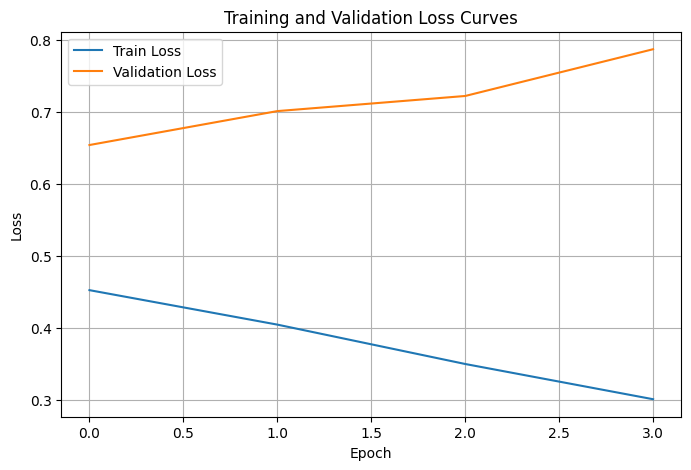

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

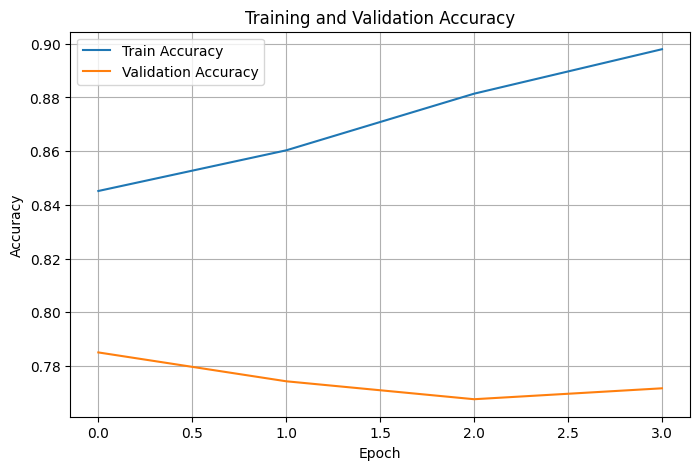

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
model.eval()
test_loss, test_correct, test_total = 0.0, 0, 0

with torch.no_grad():
    for X_batch, lengths, y_batch in tqdm(test_loader, desc="Testing"):
        X_batch, lengths, y_batch = X_batch.to(device), lengths.to(device), y_batch.to(device)
        outputs = model(X_batch, lengths)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, dim=1)
        test_correct += (predicted == y_batch).sum().item()
        test_total += y_batch.size(0)

test_loss /= test_total
test_acc = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Testing: 100%|██████████| 108/108 [00:03<00:00, 29.74it/s]

Test Loss: 0.8159 | Test Accuracy: 0.7676
